___
<h1> Machine Learning </h1>
<h2> Systems Engineering and Computer Technologies / Engenharia de Sistemas e Tecnologias Informáticas
(LESTI)</h2>
<h3> Instituto Superior de Engenharia / Universidade do Algarve </h3>

[LESTI](https://ise.ualg.pt/curso/1941) / [ISE](https://ise.ualg.pt) / [UAlg](https://www.ualg.pt)

Pedro J. S. Cardoso (pcardoso@ualg.pt)

___

# Generalization, underfitting and overfitting

Let us see some cases of "good" generalization, underfitting and overfitting

## Classification

Let us start with a classification example. We will generate some data and try to classify it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import cos

from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score

# fix seed so we can replicate ours experiments
np.random.seed(1)

In [2]:
# number of points
N = 250 

# bounding box for data
a, b = -6, 6

def f(x):
    return 4 * cos(x) 

In [3]:
xx = []
yy = []
lable_int = []
lable_color = []

for k in range(N):
    # generate a point
    x = np.random.uniform(a, b)
    y = np.random.uniform(a, b)
    
    # set point's color
    l1 = ['b','r'][int((f(x) < y))]
    l2 = int((f(x) < y))
    lable_int.append(l2)
    lable_color.append(l1)
    
    # "size" of the noise
    r = 2.
    
    # add the point to the points lists (xx and yy) but add some noise to the x and y values
    xx.append(x + (r * np.random.rand() - r/2.0))
    yy.append(y + (r * np.random.rand() - r/2.0))
    

df = pd.DataFrame()
df['x'] = np.array(xx, dtype=float)
df['y'] = np.array(yy, dtype=float)
df['label_int'] = np.array(lable_int)
df['label_color'] = np.array(lable_color)

df.head(10)

,x,y,label_int,label_color
0,-1.995507,2.248559,1,r
1,-4.866409,-5.200815,0,b
2,-1.400401,0.836240,0,b
3,-4.491798,4.878344,1,r
4,-1.711568,0.100481,0,b
5,3.235783,6.003784,1,r
6,3.686758,3.813390,1,r
7,-4.765341,4.379925,1,r
8,5.878429,0.029015,0,b
9,1.274588,4.515797,1,r


<Axes: xlabel='x', ylabel='y'>

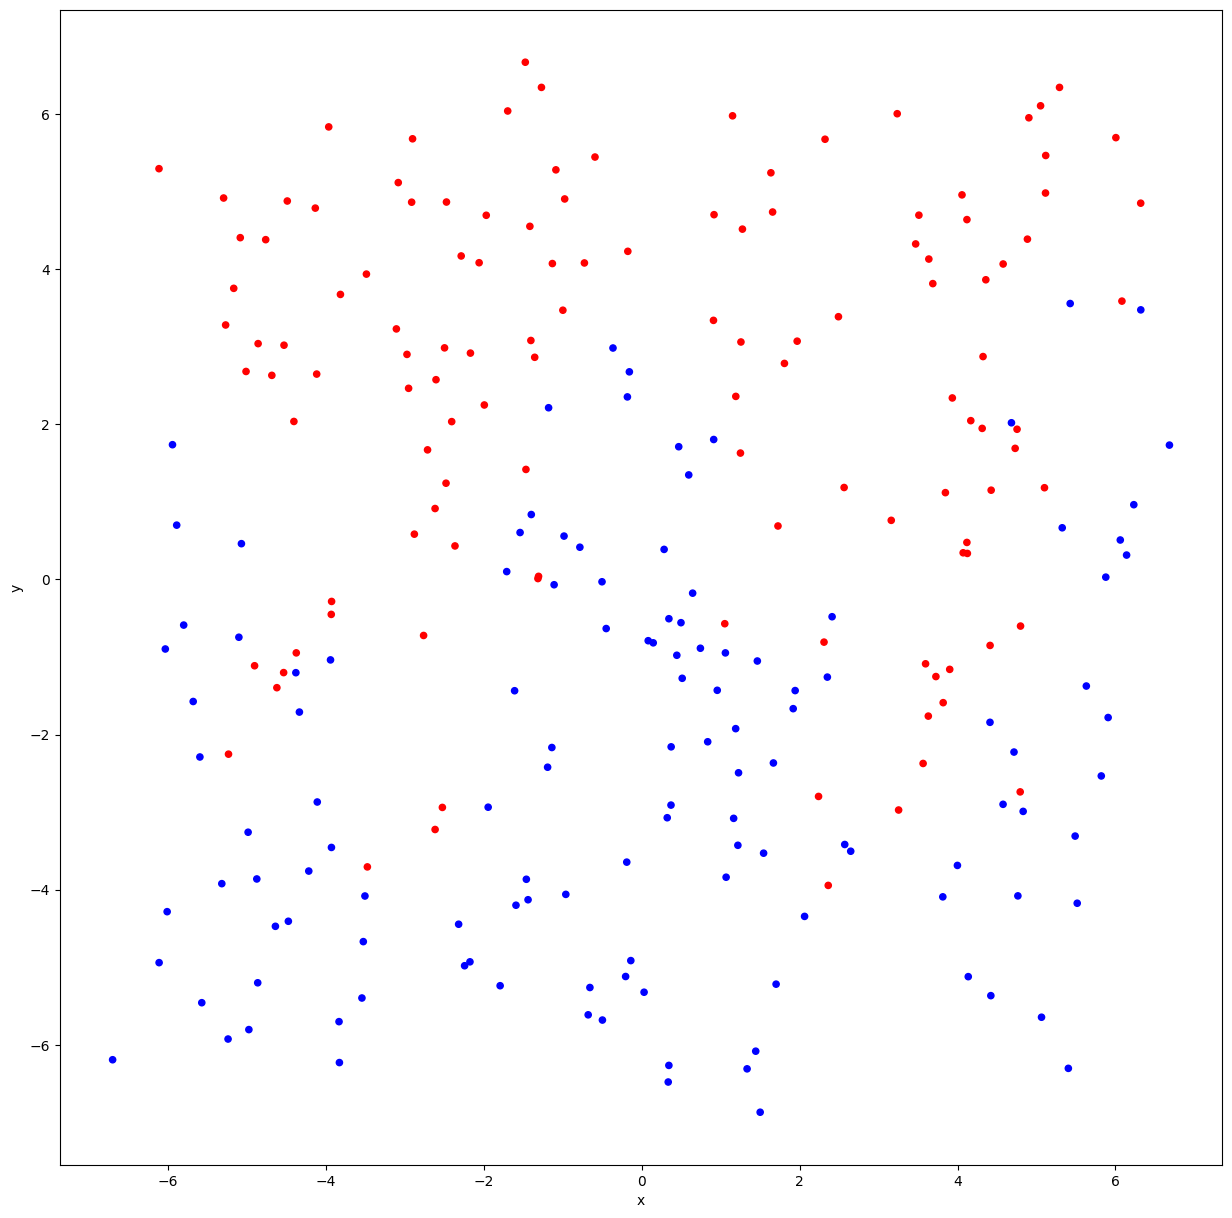

In [4]:
df.plot.scatter(x='x', y='y', c=df['label_color'], figsize=(15, 15))

In [5]:
def make_meshgrid(x, y, h=.05):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # print(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # print(Z)
    out = ax.contourf(xx, yy, Z, **params)
    return out


/var/folders/9j/nv8p1yk95y5df79ppmw307_h0000gn/T/ipykernel_24945/1258175060.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X0, X1, c=c, s=100, edgecolors='k', marker='x')
/var/folders/9j/nv8p1yk95y5df79ppmw307_h0000gn/T/ipykernel_24945/1258175060.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X0, X1, c=c, s=100, edgecolors='k', marker='x')
/var/folders/9j/nv8p1yk95y5df79ppmw307_h0000gn/T/ipykernel_24945/1258175060.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X0, X1, c=c, s=100, edgecolors='k', marker='x')


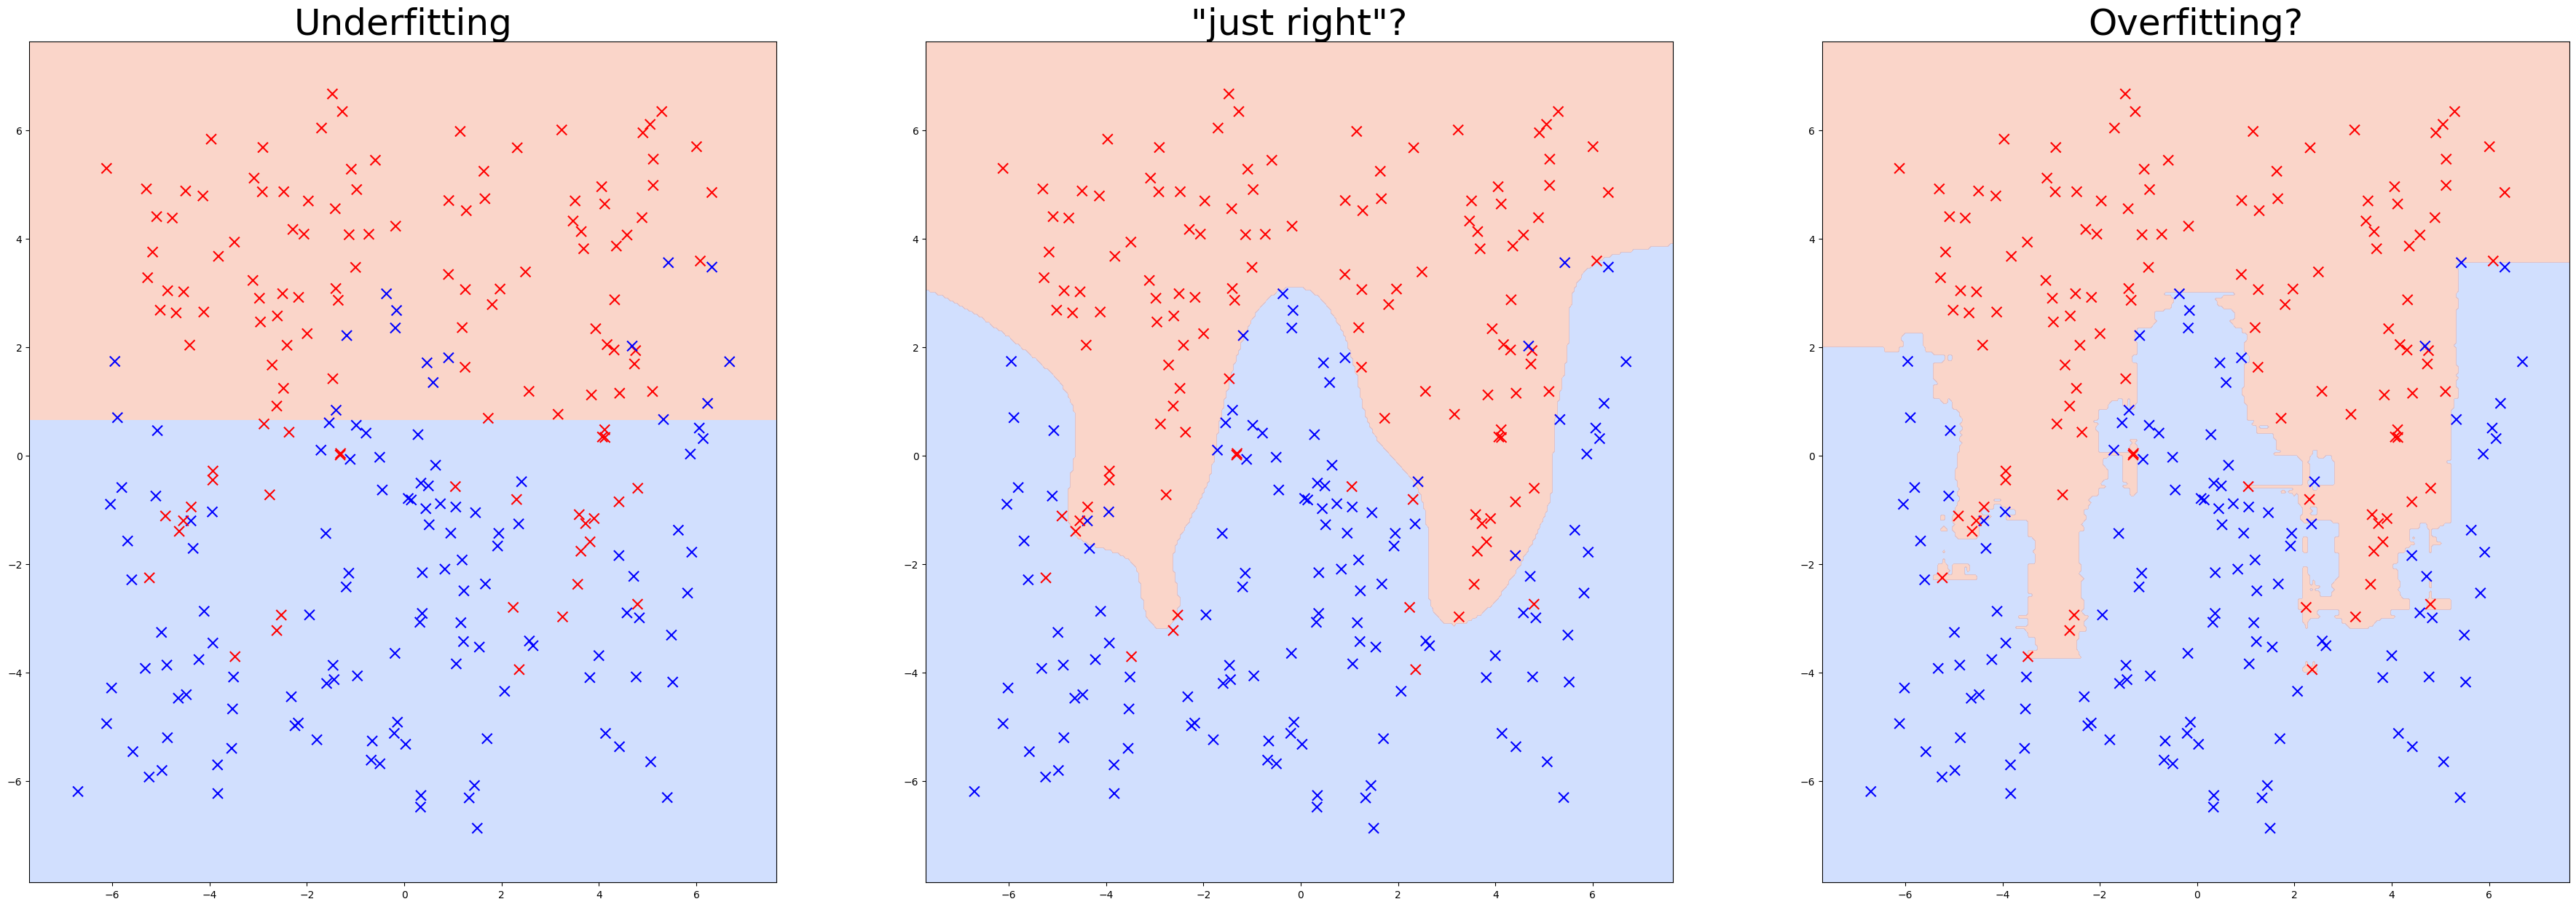

In [6]:
# title for the plots
titles = ("Underfitting", '"just right"?', "Overfitting?")

# Set-up 1x3 grid for plotting.
fig, sub = plt.subplots(1, 3, figsize=(45, 15))
# plt.subplots_adjust(wspace=0.4, hspace=0.4)

# after a "lot of test", I came with these classifiers. Don't worry with this, for now!
models = (
    RandomForestClassifier(random_state=1, n_estimators=1, max_depth=2),
    GaussianProcessClassifier(random_state=1, max_iter_predict=10),
    RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=1000),
)

X = df[['x', 'y']].values
y = df[['label_int']].values[:, 0]
models = (clf.fit(X, y) for clf in models)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
c = df[['label_color']].values[:, 0]

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.4, levels=1)
    ax.scatter(X0, X1, c=c, s=100, edgecolors='k', marker='x')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title, fontsize=36)

plt.show()

## Regression

We can do an analogous example with regression

(Adaptado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)

In [7]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

n_samples = 30
degrees = [1, 4, 99]

# random set of values between 0 and 1
X = np.sort(np.random.rand(n_samples))
# y values, with some noise
y = true_fun(X) + np.random.randn(n_samples) * 0.1

print(X)
print(y)

[0.01540352 0.03711266 0.03985993 0.04147508 0.05231295 0.13479312
 0.1934164  0.2107645  0.3218288  0.32580997 0.3356638  0.43047178
 0.43235559 0.45405906 0.46947903 0.51206103 0.53600849 0.60511678
 0.61746101 0.65620155 0.67035003 0.69385541 0.75170772 0.7626321
 0.76778898 0.82300304 0.84770047 0.87306815 0.88982734 0.95177569]
[ 0.98515129  0.91666065  0.87562307  0.97329308  1.02706405  0.85074917
  0.61081596  0.48599427  0.06886381  0.09262609 -0.01466362 -0.43069775
 -0.46493083 -0.44716124 -0.6422752  -0.72757909 -0.77691957 -0.88567818
 -0.82364848 -0.93123885 -0.93992804 -1.13882706 -0.86012963 -0.67010469
 -0.97159412 -0.84262971 -0.67911512 -0.46099169 -0.4436902  -0.27301315]


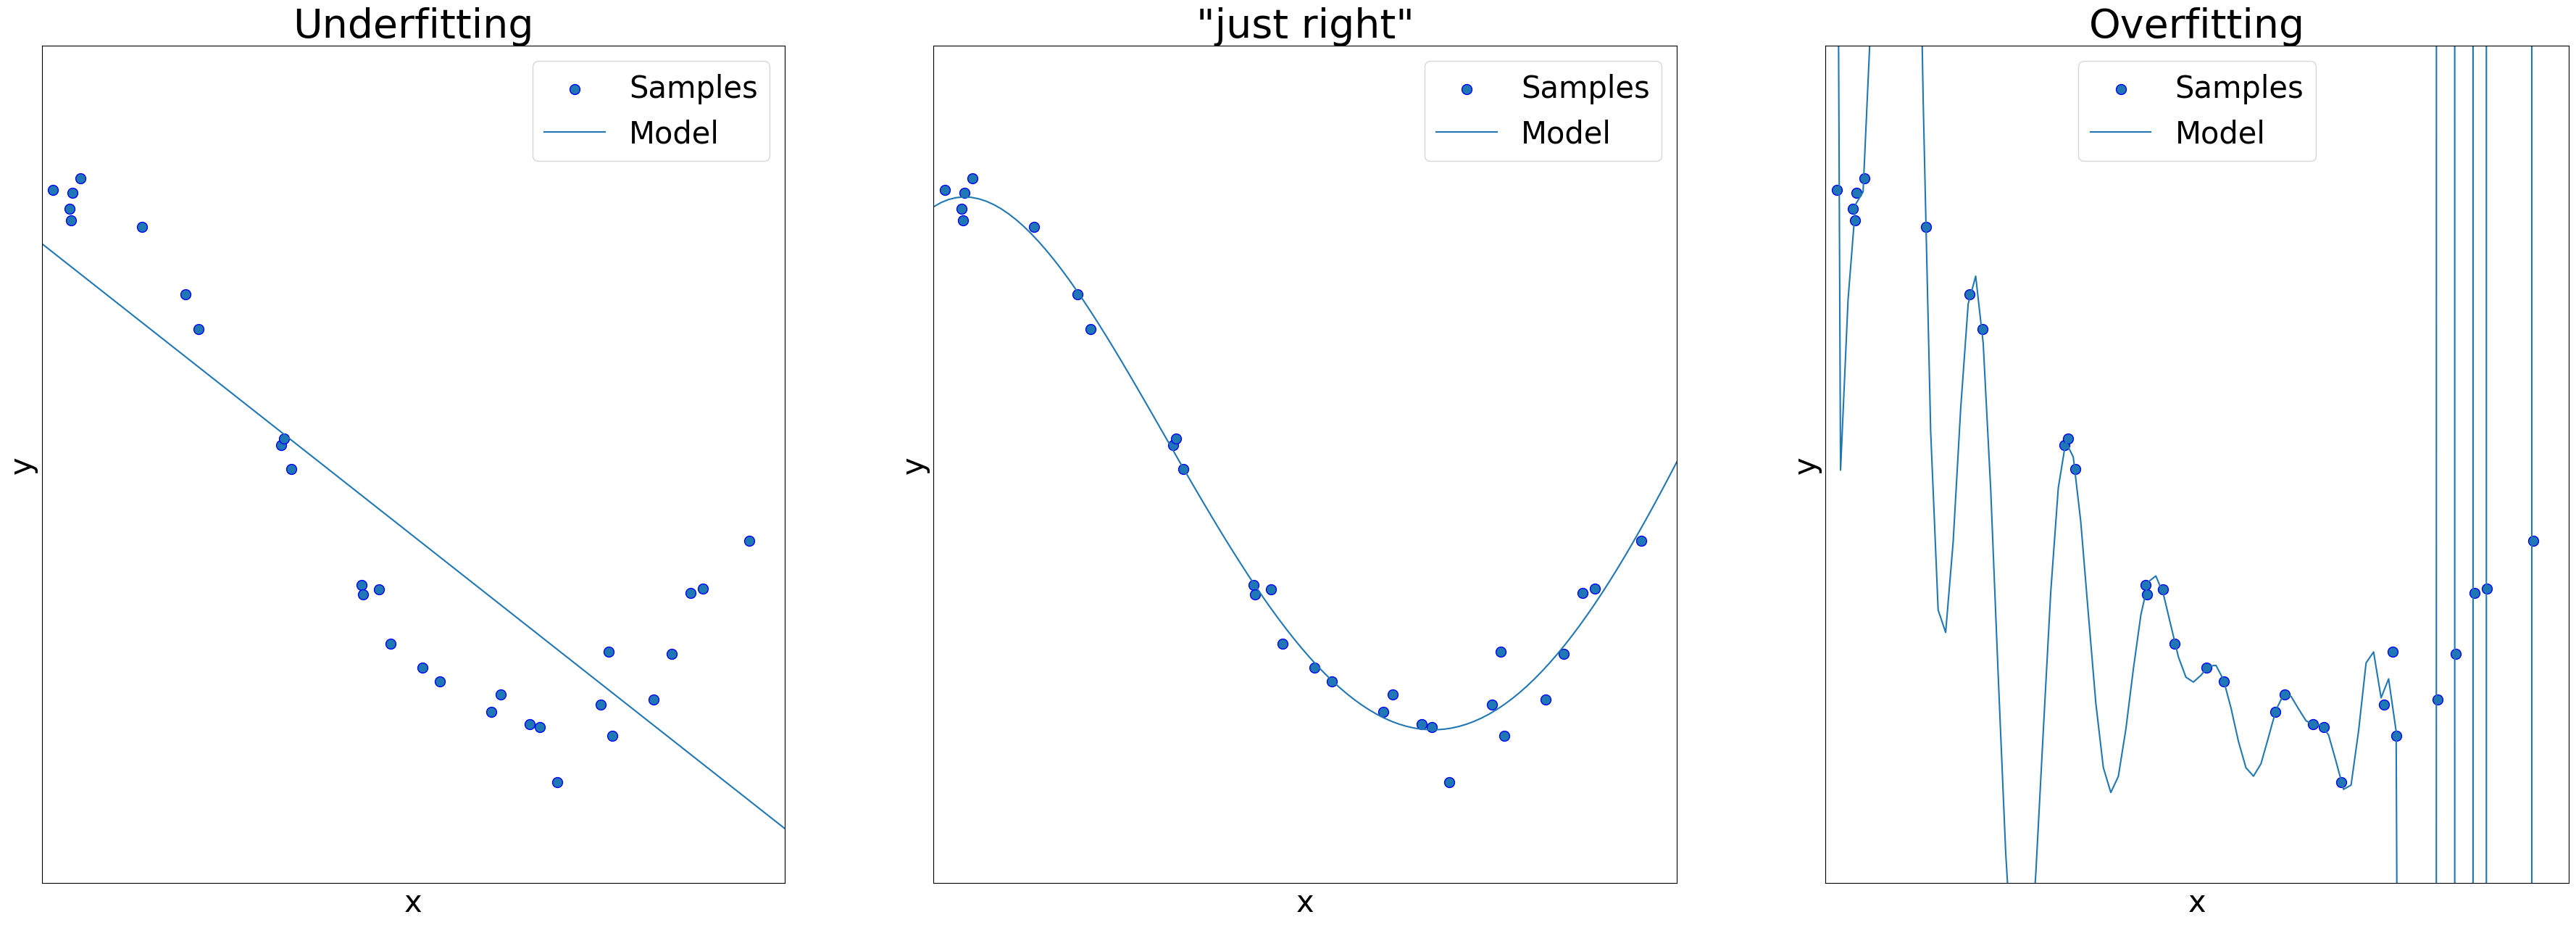

In [8]:
plt.figure(figsize=(45, 15))

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # plot the training data
    plt.scatter(X, y, edgecolor='b', s=100, label="Samples")
    # plot the prediction
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    
    plt.xlabel("x", fontsize=30)
    plt.ylabel("y", fontsize=30)
    plt.xlim((0, 1))
    plt.ylim((-1.5, 1.5))
    plt.legend(loc="best", fontsize=30)
    plt.title(("Underfitting", '"just right"', "Overfitting")[i], fontsize=40)
